In [2]:
import pickle

import pandas as pd
import numpy as np

# Se leen los datos preprocesados

In [3]:
with open("../../data/bicycles/df_bicycles_preprocesed.pk1", "rb") as f:
    df_bicycles = pickle.load(f)
    
with open("../../data/weather/df_weather_preprocesed.pk1", "rb") as f:
    df_weather = pickle.load(f)    

# Me aseguro de que la columna que contiene la fecha es del tipo datetime

In [4]:
df_bicycles.dtypes

ride_id                      object
rideable_type                object
started_at           datetime64[ns]
ended_at             datetime64[ns]
start_station_id             object
end_station_id               object
member_casual                object
year                          int64
month                         int64
day                           int64
time_hms_ms         timedelta64[ns]
day_type                     object
event                          bool
dtype: object

In [5]:
df_weather.dtypes

DATE                      datetime64[ns]
temperature                      float64
wind_speed                       float64
relative_humidity                float64
station_level_pressure           float64
year                               int32
month                              int32
day                                int32
time_hms_ms                       object
dtype: object

# Se realiza un merge con 'neares' para buscar la hora mas cercana

In [6]:
df_bicycles_sorted = df_bicycles.sort_values('started_at')
df_weather_sorted = df_weather.sort_values('DATE')

df_merged = pd.merge_asof(
    df_bicycles_sorted,
    df_weather_sorted,
    left_on='started_at',
    right_on='DATE',
    direction='nearest',
    tolerance=pd.Timedelta('1h') # Se ajusta lo que se considera el mas cercano
)

# Se seleccionan solo columnas numéricas (float o int)
weather_cols_numeric = df_weather.select_dtypes(include=['float64']).columns.tolist()

for col in weather_cols_numeric:
    mask_missing = df_merged[col].isna()
    
    # Media móvil
    df_merged.loc[mask_missing, col] = (
        df_merged[col].fillna(
            df_merged[col].rolling(window=10, min_periods=1).mean()
        )
    )

# Se realizan comprobaciones de los datos

## Se borra la columna DATE

In [7]:
# Columnas a eliminar
cols_to_drop = ["DATE"]

# Crear una copia del DataFrame sin esas columnas
df_merged = df_merged.drop(columns=cols_to_drop).copy()


## Se observan los valores nulos

In [8]:
df_merged.isna().sum()

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_id          0
end_station_id            0
member_casual             0
year_x                    0
month_x                   0
day_x                     0
time_hms_ms_x             0
day_type                  0
event                     0
temperature               0
wind_speed                0
relative_humidity         0
station_level_pressure    0
year_y                    0
month_y                   0
day_y                     0
time_hms_ms_y             0
dtype: int64

## Se comprueba la cantidad de datos en las columnas

In [9]:
df_merged["ride_id"].count()

np.int64(9969971)

In [10]:
df_merged.describe()

,started_at,ended_at,year_x,month_x,day_x,time_hms_ms_x,temperature,wind_speed,relative_humidity,station_level_pressure,year_y,month_y,day_y
count,9969971,9969971,9.969971e+06,9.969971e+06,9.969971e+06,9969971,9.969971e+06,9.969971e+06,9.969971e+06,9.969971e+06,9.969971e+06,9.969971e+06,9.969971e+06
mean,2023-03-13 02:04:12.545116416,2023-03-13 02:20:39.132660992,2.022689e+03,6.593871e+00,1.572793e+01,0 days 14:36:09.941747974,1.739474e+01,4.353604e+00,5.871269e+01,9.933005e+02,2.022689e+03,6.593952e+00,1.572815e+01
min,2022-01-01 00:00:05,2022-01-01 00:01:48,2.022000e+03,1.000000e+00,1.000000e+00,0 days 00:00:00,-2.280000e+01,0.000000e+00,1.507547e+01,9.586000e+02,2.022000e+03,1.000000e+00,1.000000e+00
25%,2022-08-04 18:02:25.500000,2022-08-04 18:19:17,2.022000e+03,5.000000e+00,8.000000e+00,0 days 11:12:56,1.060000e+01,2.866667e+00,4.523333e+01,9.893600e+02,2.022000e+03,5.000000e+00,8.000000e+00
50%,2023-04-12 17:11:21,2023-04-12 17:27:46,2.023000e+03,7.000000e+00,1.600000e+01,0 days 15:26:42,1.940000e+01,4.184906e+00,5.891071e+01,9.932283e+02,2.023000e+03,7.000000e+00,1.600000e+01
75%,2023-09-08 12:05:13,2023-09-08 12:18:53.500000,2.023000e+03,9.000000e+00,2.300000e+01,0 days 18:08:37,2.494000e+01,5.701887e+00,7.225000e+01,9.970550e+02,2.023000e+03,9.000000e+00,2.300000e+01
max,2024-05-31 23:59:47,2024-06-01 17:56:00,2.024000e+03,1.200000e+01,3.100000e+01,0 days 23:59:59,3.830000e+01,1.650000e+01,1.000000e+02,1.016800e+03,2.024000e+03,1.200000e+01,3.100000e+01
std,NaN,NaN,6.846879e-01,2.746763e+00,8.774949e+00,0 days 04:52:43.867316925,9.627336e+00,2.177061e+00,1.735138e+01,6.276062e+00,6.846853e-01,2.746761e+00,8.774956e+00


# Se observan las columnas finales

In [11]:
df_merged.dtypes

ride_id                            object
rideable_type                      object
started_at                 datetime64[ns]
ended_at                   datetime64[ns]
start_station_id                   object
end_station_id                     object
member_casual                      object
year_x                              int64
month_x                             int64
day_x                               int64
time_hms_ms_x             timedelta64[ns]
day_type                           object
event                                bool
temperature                       float64
wind_speed                        float64
relative_humidity                 float64
station_level_pressure            float64
year_y                              int32
month_y                             int32
day_y                               int32
time_hms_ms_y                      object
dtype: object

# Se guardan los datos

In [12]:
df_merged.to_pickle("../../data/join/df_data.pk1")

# Se muestran graficas de los datos

In [19]:
with open("../../data/join/df_data.pk1", "rb") as f:
    df = pickle.load(f)

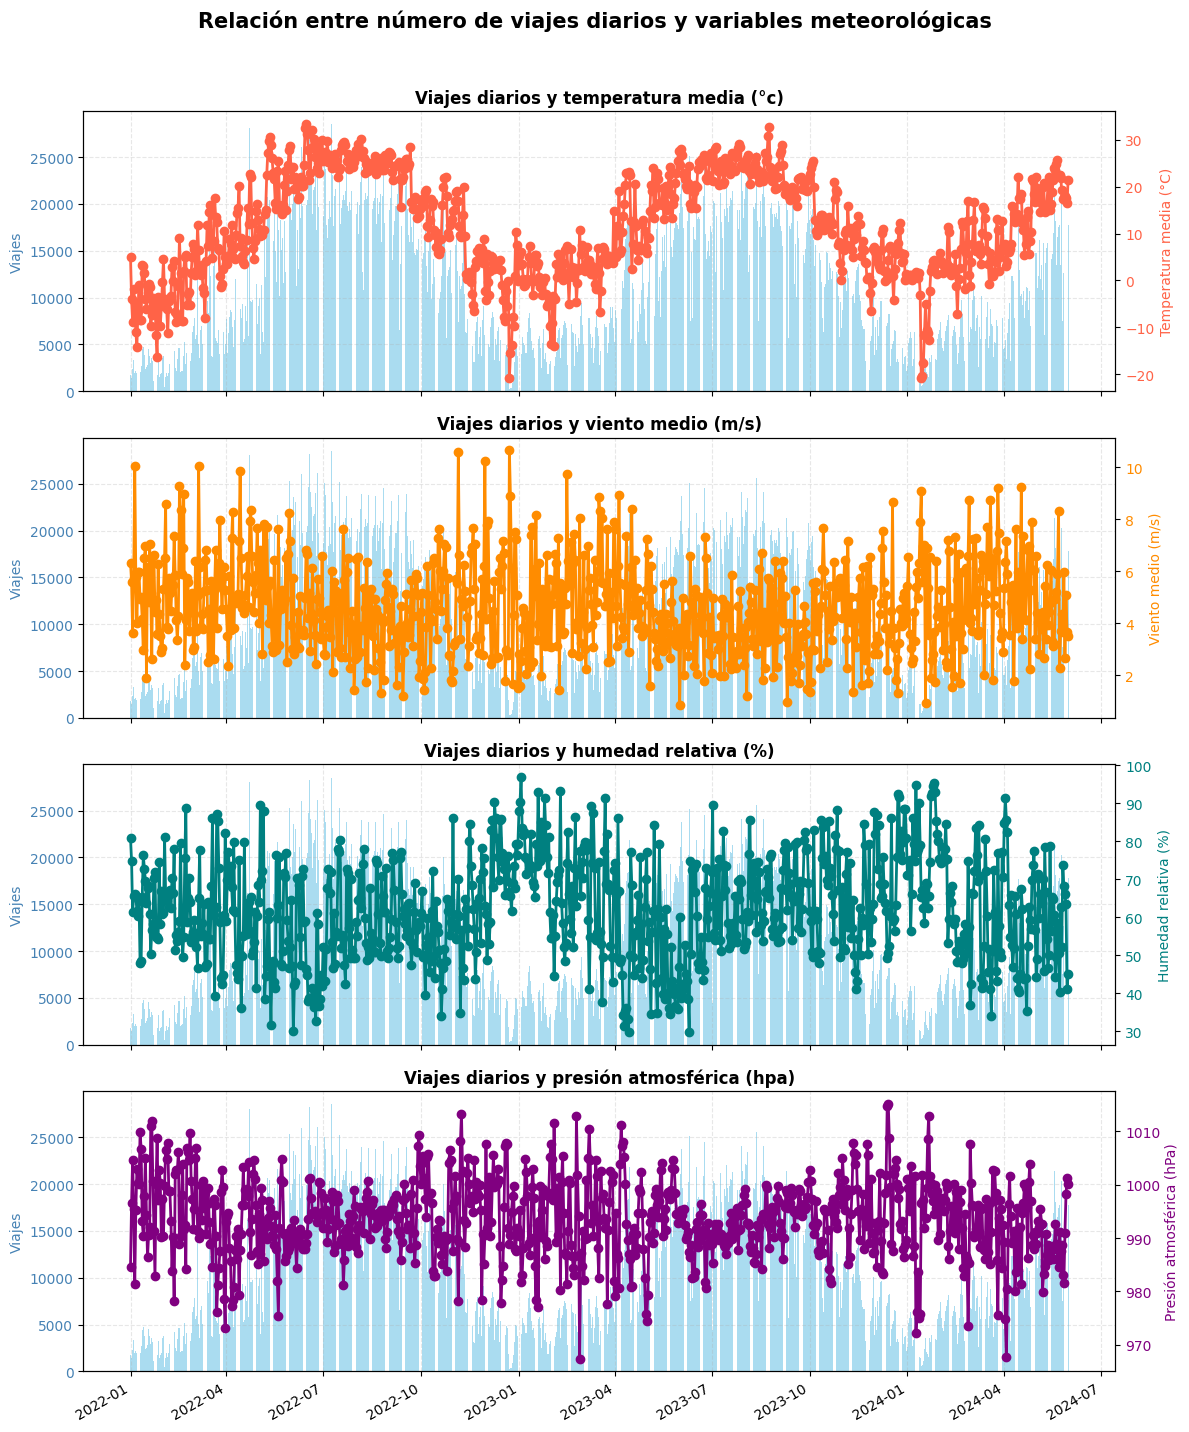

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar que la columna de fecha sea datetime
df['started_at'] = pd.to_datetime(df['started_at'])

# Agrupar por día y calcular medias
df_daily = (
    df.groupby(df['started_at'].dt.date)
    .agg(
        trips=('started_at', 'count'),
        mean_temp=('temperature', 'mean'),
        mean_wind=('wind_speed', 'mean'),
        mean_humidity=('relative_humidity', 'mean'),
        mean_pressure=('station_level_pressure', 'mean')
    )
    .reset_index()
)

# Configurar figura con 4 subgráficos
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

# Lista de variables y etiquetas
metrics = [
    ('mean_temp', 'Temperatura media (°C)', 'tomato'),
    ('mean_wind', 'Viento medio (m/s)', 'darkorange'),
    ('mean_humidity', 'Humedad relativa (%)', 'teal'),
    ('mean_pressure', 'Presión atmosférica (hPa)', 'purple')
]

# Dibujar cada gráfico
for ax, (col, ylabel, color) in zip(axes, metrics):
    # Eje izquierdo: número de viajes
    ax.bar(df_daily['started_at'], df_daily['trips'], color='skyblue', alpha=0.7, label='Viajes por día')
    ax.set_ylabel('Viajes', color='steelblue')
    ax.tick_params(axis='y', labelcolor='steelblue')
    
    # Eje derecho: variable meteorológica
    ax2 = ax.twinx()
    ax2.plot(df_daily['started_at'], df_daily[col], color=color, marker='o', linewidth=2, label=ylabel)
    ax2.set_ylabel(ylabel, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Título de cada subgráfico
    ax.set_title(f'Viajes diarios y {ylabel.lower()}', fontsize=12, weight='bold')
    ax.grid(True, linestyle='--', alpha=0.3)

# Formato general
plt.suptitle('Relación entre número de viajes diarios y variables meteorológicas', fontsize=15, weight='bold', y=1.02)
plt.xlabel('Fecha')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


# Grado de correlacion

In [21]:
correlations = df_daily[['trips', 'mean_temp', 'mean_wind', 'mean_humidity', 'mean_pressure']].corr()

print(correlations['trips'])

trips            1.000000
mean_temp        0.889446
mean_wind       -0.253475
mean_humidity   -0.433864
mean_pressure   -0.061751
Name: trips, dtype: float64


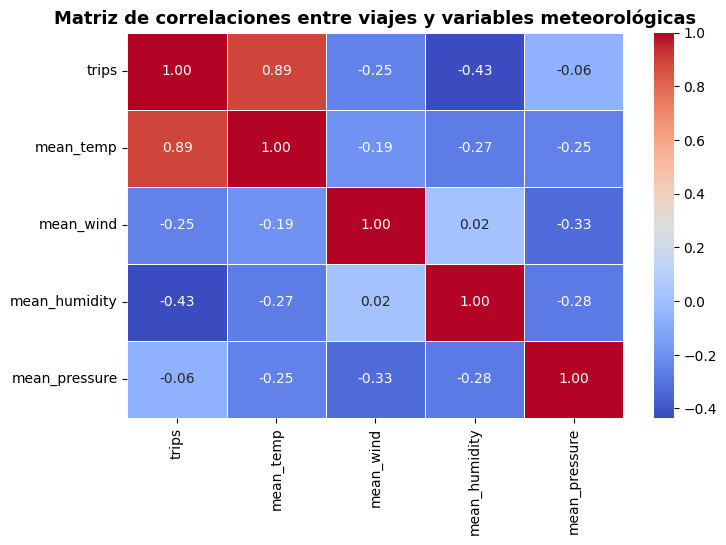

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlaciones entre viajes y variables meteorológicas', fontsize=13, weight='bold')
plt.show()

C:\Users\burvu\AppData\Local\Temp\ipykernel_5932\3898134966.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\burvu\AppData\Local\Temp\ipykernel_5932\3898134966.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\burvu\AppData\Local\Temp\ipykernel_5932\3898134966.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\burvu\AppData\Local\Temp\ipykernel_5932\3898134966.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

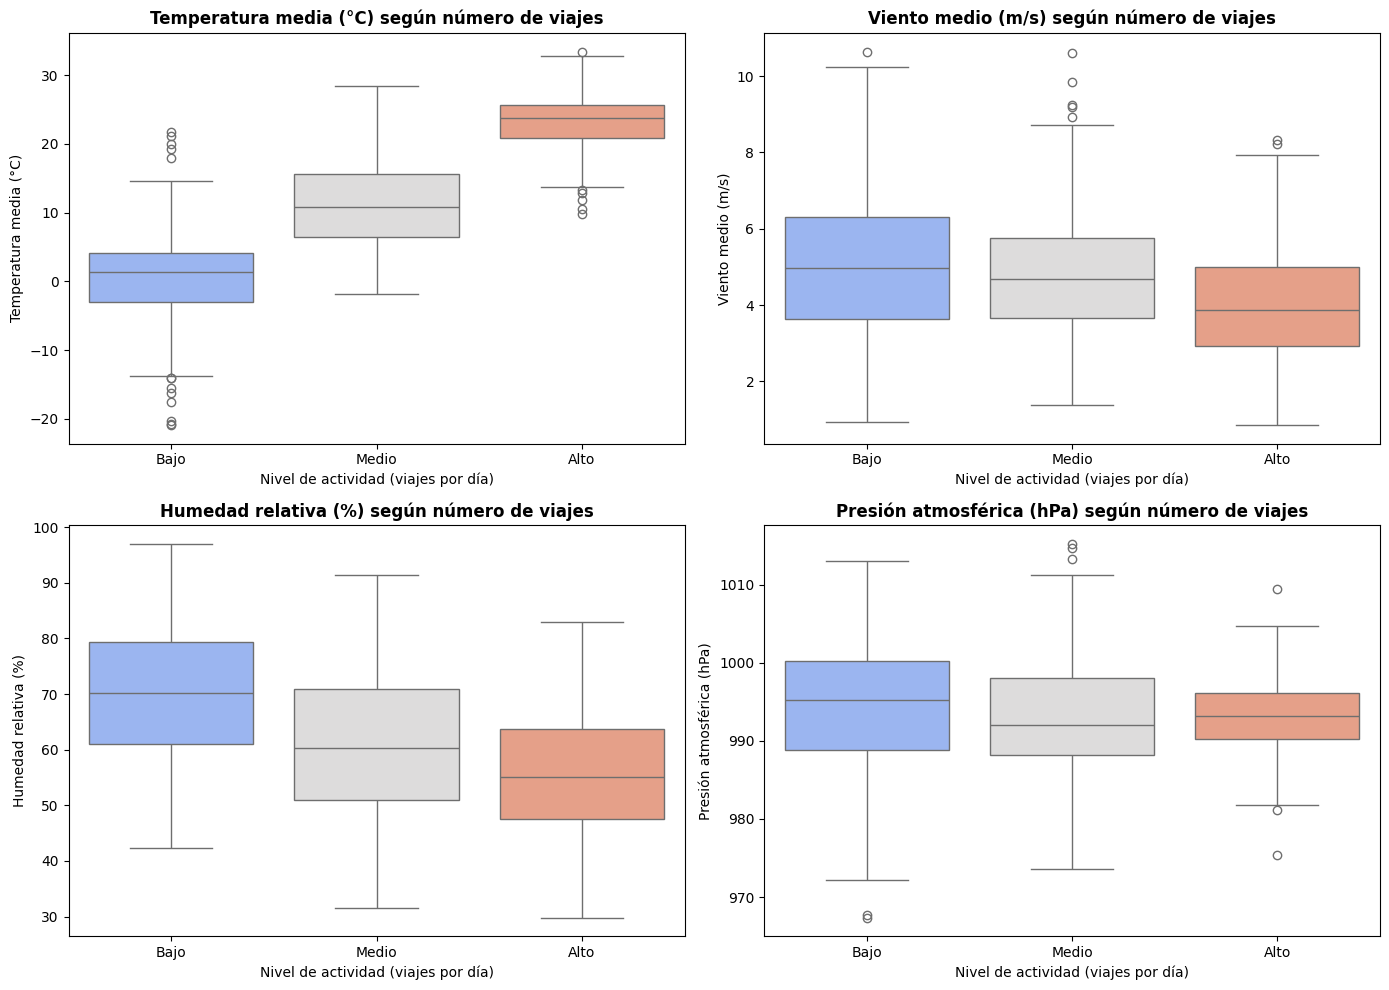

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear categorías de viajes (bajo/medio/alto) si no se ha hecho aún
df_daily['viajes_cat'] = pd.qcut(df_daily['trips'], q=3, labels=['Bajo', 'Medio', 'Alto'])

# Lista de variables meteorológicas y sus etiquetas
variables = {
    'mean_temp': 'Temperatura media (°C)',
    'mean_wind': 'Viento medio (m/s)',
    'mean_humidity': 'Humedad relativa (%)',
    'mean_pressure': 'Presión atmosférica (hPa)'
}

# Configurar figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()  # Convertir a lista para iterar fácilmente

# Dibujar boxplot para cada variable
for ax, (var, label) in zip(axes, variables.items()):
    sns.boxplot(
        x='viajes_cat',
        y=var,
        data=df_daily,
        palette='coolwarm',
        ax=ax
    )
    ax.set_title(f'{label} según número de viajes', fontsize=12, weight='bold')
    ax.set_xlabel('Nivel de actividad (viajes por día)')
    ax.set_ylabel(label)

# Ajustar diseño
plt.tight_layout()
plt.show()


# Analisis de dias festivos y días con evento

C:\Users\burvu\AppData\Local\Temp\ipykernel_5932\1615222360.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


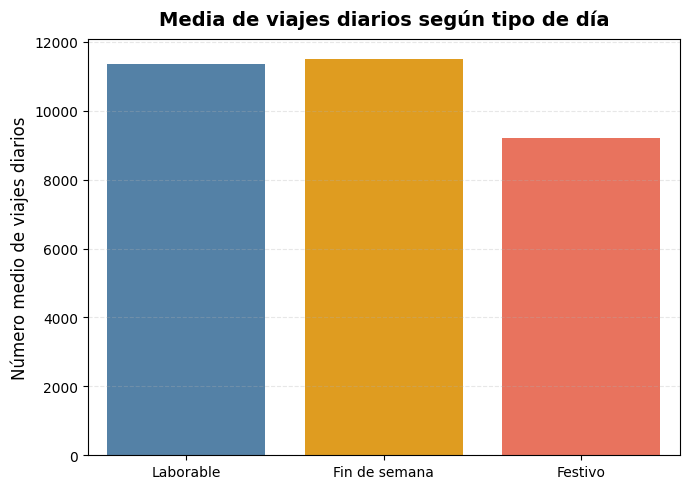

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Agrupar por día para contar los viajes y conservar el tipo de día
df_daily = (
    df.groupby([df['started_at'].dt.date, 'day_type'])
    .agg(trips=('started_at', 'count'))
    .reset_index()
)

# Calcular la media de viajes para cada tipo de día
df_summary = (
    df_daily.groupby('day_type', as_index=False)
    .agg(mean_trips=('trips', 'mean'))
)

# Orden lógico de categorías
order = ['Normal', 'Weekend', 'Holiday']

# Etiquetas más legibles
labels = {
    'Normal': 'Laborable',
    'Weekend': 'Fin de semana',
    'Holiday': 'Festivo'
}
df_summary['Tipo de día'] = df_summary['day_type'].map(labels)

plt.figure(figsize=(7,5))
sns.barplot(
    data=df_summary,
    x='Tipo de día',
    y='mean_trips',
    order=[labels[o] for o in order],
    palette=['steelblue', 'orange', 'tomato']
)

# Estilo y etiquetas
plt.title('Media de viajes diarios según tipo de día', fontsize=14, weight='bold', pad=10)
plt.xlabel('')
plt.ylabel('Número medio de viajes diarios', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\burvu\AppData\Local\Temp\ipykernel_5932\2586726682.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


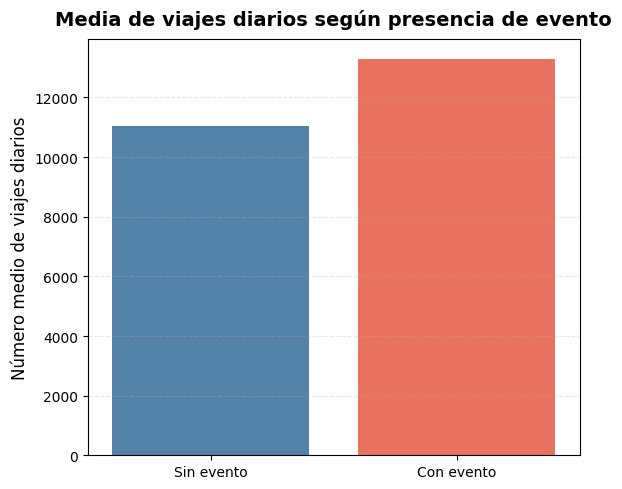

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurar que la columna de fecha es datetime
df['started_at'] = pd.to_datetime(df['started_at'])

# Agrupar por día y por evento
df_daily = (
    df.groupby([df['started_at'].dt.date, 'event'])
    .agg(trips=('started_at', 'count'))
    .reset_index()
)

# Calcular la media de viajes para cada tipo de evento
df_summary = (
    df_daily.groupby('event', as_index=False)
    .agg(mean_trips=('trips', 'mean'))
)

# Mapear etiquetas legibles
labels = {False: 'Sin evento', True: 'Con evento'}
df_summary['Evento'] = df_summary['event'].map(labels)

plt.figure(figsize=(6,5))
sns.barplot(
    data=df_summary,
    x='Evento',
    y='mean_trips',
    palette=['steelblue', 'tomato']
)

# Estilo y etiquetas
plt.title('Media de viajes diarios según presencia de evento', fontsize=14, weight='bold', pad=10)
plt.xlabel('')
plt.ylabel('Número medio de viajes diarios', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [26]:
df_daily = (
    df.groupby([df['started_at'].dt.date, 'day_type'])
    .agg(trips=('started_at', 'count'))
    .reset_index()
)

df_daily["normal"] = df_daily["day_type"] == "Normal"
df_daily["weekend"] = df_daily["day_type"] == "Weekend"
df_daily["holiday"] = df_daily["day_type"] == "Holiday"

# Calcular correlación de Pearson con trips
corr_normal = df_daily['trips'].corr(df_daily['normal'])
corr_weekend = df_daily['trips'].corr(df_daily['weekend'])
corr_holiday = df_daily['trips'].corr(df_daily['holiday'])
print(f"Correlación entre tipo de día 'Normal' y número de viajes: {corr_normal:.3f}")
print(f"Correlación entre tipo de día 'Weekend' y número de viajes: {corr_weekend:.3f}")
print(f"Correlación entre tipo de día 'Holiday' y número de viajes: {corr_holiday:.3f}")

Correlación entre tipo de día 'Normal' y número de viajes: 0.011
Correlación entre tipo de día 'Weekend' y número de viajes: 0.019
Correlación entre tipo de día 'Holiday' y número de viajes: -0.068


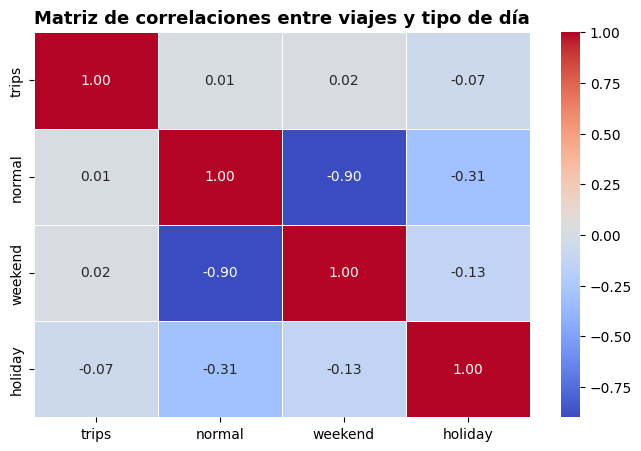

In [27]:
df_daily = (
    df.groupby([df['started_at'].dt.date, 'day_type'])
    .agg(trips=('started_at', 'count'))
    .reset_index()
)

df_daily["normal"] = df_daily["day_type"] == "Normal"
df_daily["weekend"] = df_daily["day_type"] == "Weekend"
df_daily["holiday"] = df_daily["day_type"] == "Holiday"

cor = df_daily[['trips', 'normal', 'weekend', 'holiday']].corr()


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlaciones entre viajes y tipo de día', fontsize=13, weight='bold')
plt.show()


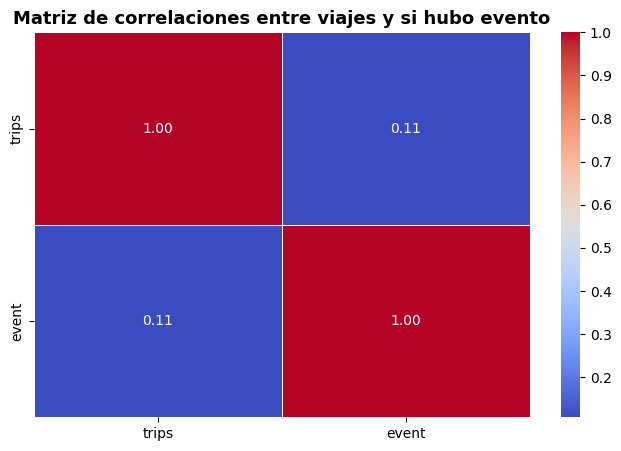

In [28]:
df_daily = (
    df.groupby([df['started_at'].dt.date, 'event'])
    .agg(trips=('started_at', 'count'))
    .reset_index()
)

cor = df_daily[['trips', 'event']].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlaciones entre viajes y si hubo evento', fontsize=13, weight='bold')
plt.show()

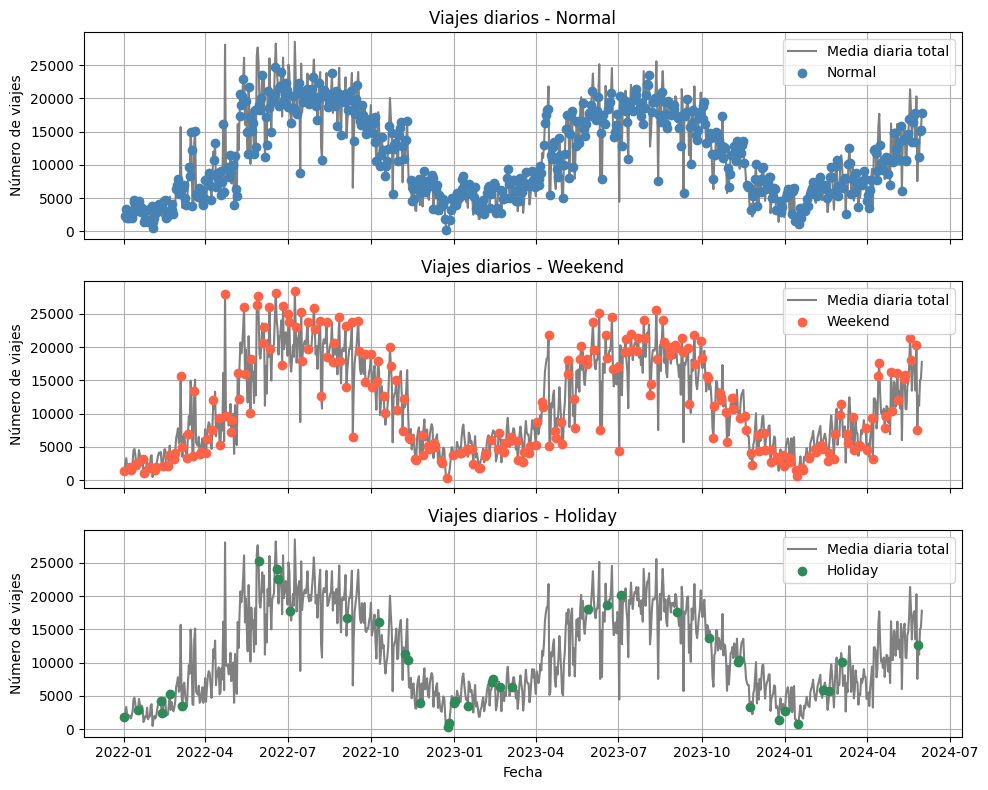

In [29]:
import matplotlib.pyplot as plt

df_daily = (
    df.groupby([df['started_at'].dt.date, 'day_type'])
    .agg(trips=('started_at', 'count'))
    .reset_index()
)

# Calcular la media total diaria
df_mean = (
    df_daily.groupby("started_at", as_index=False)
    .agg(trips=("trips", "mean"))
)

# Unir con la información del tipo de día
df_plot = df_mean.merge(
    df_daily[["started_at", "day_type"]],
    on="started_at",
    how="left"
).drop_duplicates(subset=["started_at"])

# Crear figura con tres subgráficos (uno por tipo de día)
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

day_types = ["Normal", "Weekend", "Holiday"]
colors = ["steelblue", "tomato", "seagreen"]

for ax, d_type, color in zip(axes, day_types, colors):
    # Línea de la media total diaria
    ax.plot(df_plot["started_at"], df_plot["trips"], color="gray", label="Media diaria total")
    
    # Puntos del tipo de día actual
    subset = df_plot[df_plot["day_type"] == d_type]
    ax.scatter(subset["started_at"], subset["trips"], color=color, label=d_type, zorder=5)
    
    ax.set_title(f"Viajes diarios - {d_type}")
    ax.set_ylabel("Número de viajes")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Fecha")
plt.tight_layout()
plt.show()


In [30]:
df.dtypes

ride_id                            object
rideable_type                      object
started_at                 datetime64[ns]
ended_at                   datetime64[ns]
start_station_id                   object
end_station_id                     object
member_casual                      object
year_x                              int64
month_x                             int64
day_x                               int64
time_hms_ms_x             timedelta64[ns]
day_type                           object
event                                bool
temperature                       float64
wind_speed                        float64
relative_humidity                 float64
station_level_pressure            float64
year_y                              int32
month_y                             int32
day_y                               int32
time_hms_ms_y                      object
dtype: object

In [31]:
df_daily = (
    df.groupby([df['started_at'].dt.date, 'event'])
    .agg(trips=('started_at', 'count'))
    .reset_index()
)

df_daily.dtypes

started_at    object
event           bool
trips          int64
dtype: object

In [ ]:
import matplotlib.pyplot as plt

df_daily = (
    df.groupby([df['started_at'].dt.date, 'event'])
    .agg(trips=('started_at', 'count'))
    .reset_index()
)

# Calcular la media total diaria
df_mean = (
    df_daily.groupby("started_at", as_index=False)
    .agg(trips=("trips", "mean"))
)

# Unir con la información del tipo de día
df_plot = df_mean.merge(
    df_daily[["started_at", "event"]],
    on="started_at",
    how="left"
).drop_duplicates(subset=["started_at"])

# Crear figura con tres subgráficos (uno por tipo de día)
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

day_types = ["Event", "No Event"]
colors = ["steelblue", "tomato"]

for ax, d_type, color in zip(axes, day_types, colors):
    # Línea de la media total diaria
    ax.plot(df_plot["started_at"], df_plot["trips"], color="gray", label="Media diaria total")
    
    # Puntos del tipo de día actual
    subset = df_plot[df_plot["day_type"] == d_type]
    ax.scatter(subset["started_at"], subset["trips"], color=color, label=d_type, zorder=5)
    
    ax.set_title(f"Viajes diarios - {d_type}")
    ax.set_ylabel("Número de viajes")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Fecha")
plt.tight_layout()
plt.show()


KeyError: "Column(s) ['trips'] do not exist"